In [10]:
# let's try using linear regression to predict the label using the irregularity score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

# Create a support vector classifier
from sklearn.svm import SVC

# Create a Bayesian optimization
from bayes_opt import BayesianOptimization

# Create a K-Nearest Neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

# Create a Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# visualize using pairplot
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# load the results
pan_tompkins_results = pd.read_csv('results/pan_tomkins_features.csv')
pan_tompkins_results = pan_tompkins_results.dropna().drop('record_name', axis=1)
print('results shape:', pan_tompkins_results.shape)
display(pan_tompkins_results.head())


results shape: (8514, 24)


,rr_mean,rr_std,rmssd,hr_mean,hr_std,min_hr,max_hr,pnn50,signal_power,signal_energy,...,pq_interval,qrs_duration,st_interval,p_wave_presence,t_wave_presence,p_p_interval_mean,p_p_interval_std,qt_interval,total_beat_duration,label
0,0.761667,0.033093,0.762385,78.922970,3.034465,74.296864,83.606124,0.000000,0.024269,218.421638,...,0.060877,0.114035,0.177018,True,True,0.765946,0.047205,0.397105,0.520351,N
1,0.828190,0.292269,0.878249,80.349800,28.234091,57.219727,149.099422,22.857143,0.025060,225.539144,...,0.685758,0.105686,0.222353,True,True,0.876563,0.339877,0.437549,0.380404,N
2,0.725958,0.093160,0.731911,83.680853,11.145762,73.084886,139.157484,5.000000,0.013390,241.014815,...,1.793111,0.154208,1.226752,True,True,0.784730,0.236958,1.465043,0.545289,N
3,0.947111,0.178939,0.963866,65.549921,7.473624,51.849673,80.839768,0.000000,0.036410,327.687533,...,0.305397,5.314697,0.188222,True,True,1.379167,0.930805,5.058939,5.067302,A
4,0.542324,0.223975,0.586754,126.105336,27.886241,65.376137,178.324112,66.055046,0.037288,671.189505,...,7.188465,2.676229,0.196208,True,True,0.775644,0.401576,2.416195,8.549605,A


In [12]:
labels = pan_tompkins_results['label']
# remove rows with NaN
print(labels.value_counts())



label
N    5044
O    2449
A     737
~     284
Name: count, dtype: int64


In [13]:
#resampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# pipeline
from imblearn.pipeline import Pipeline

resampling_methods = {
    'No Resampling': None,
    'Random Undersampling': RandomUnderSampler(random_state=143),
    'Random Oversampling': RandomOverSampler(random_state=143),
    'SMOTE': SMOTE(random_state=143),
    'ADASYN': ADASYN(random_state=143),
    'Tomek Links': TomekLinks(),
    'SMOTE + Tomek': SMOTETomek(random_state=143)
}

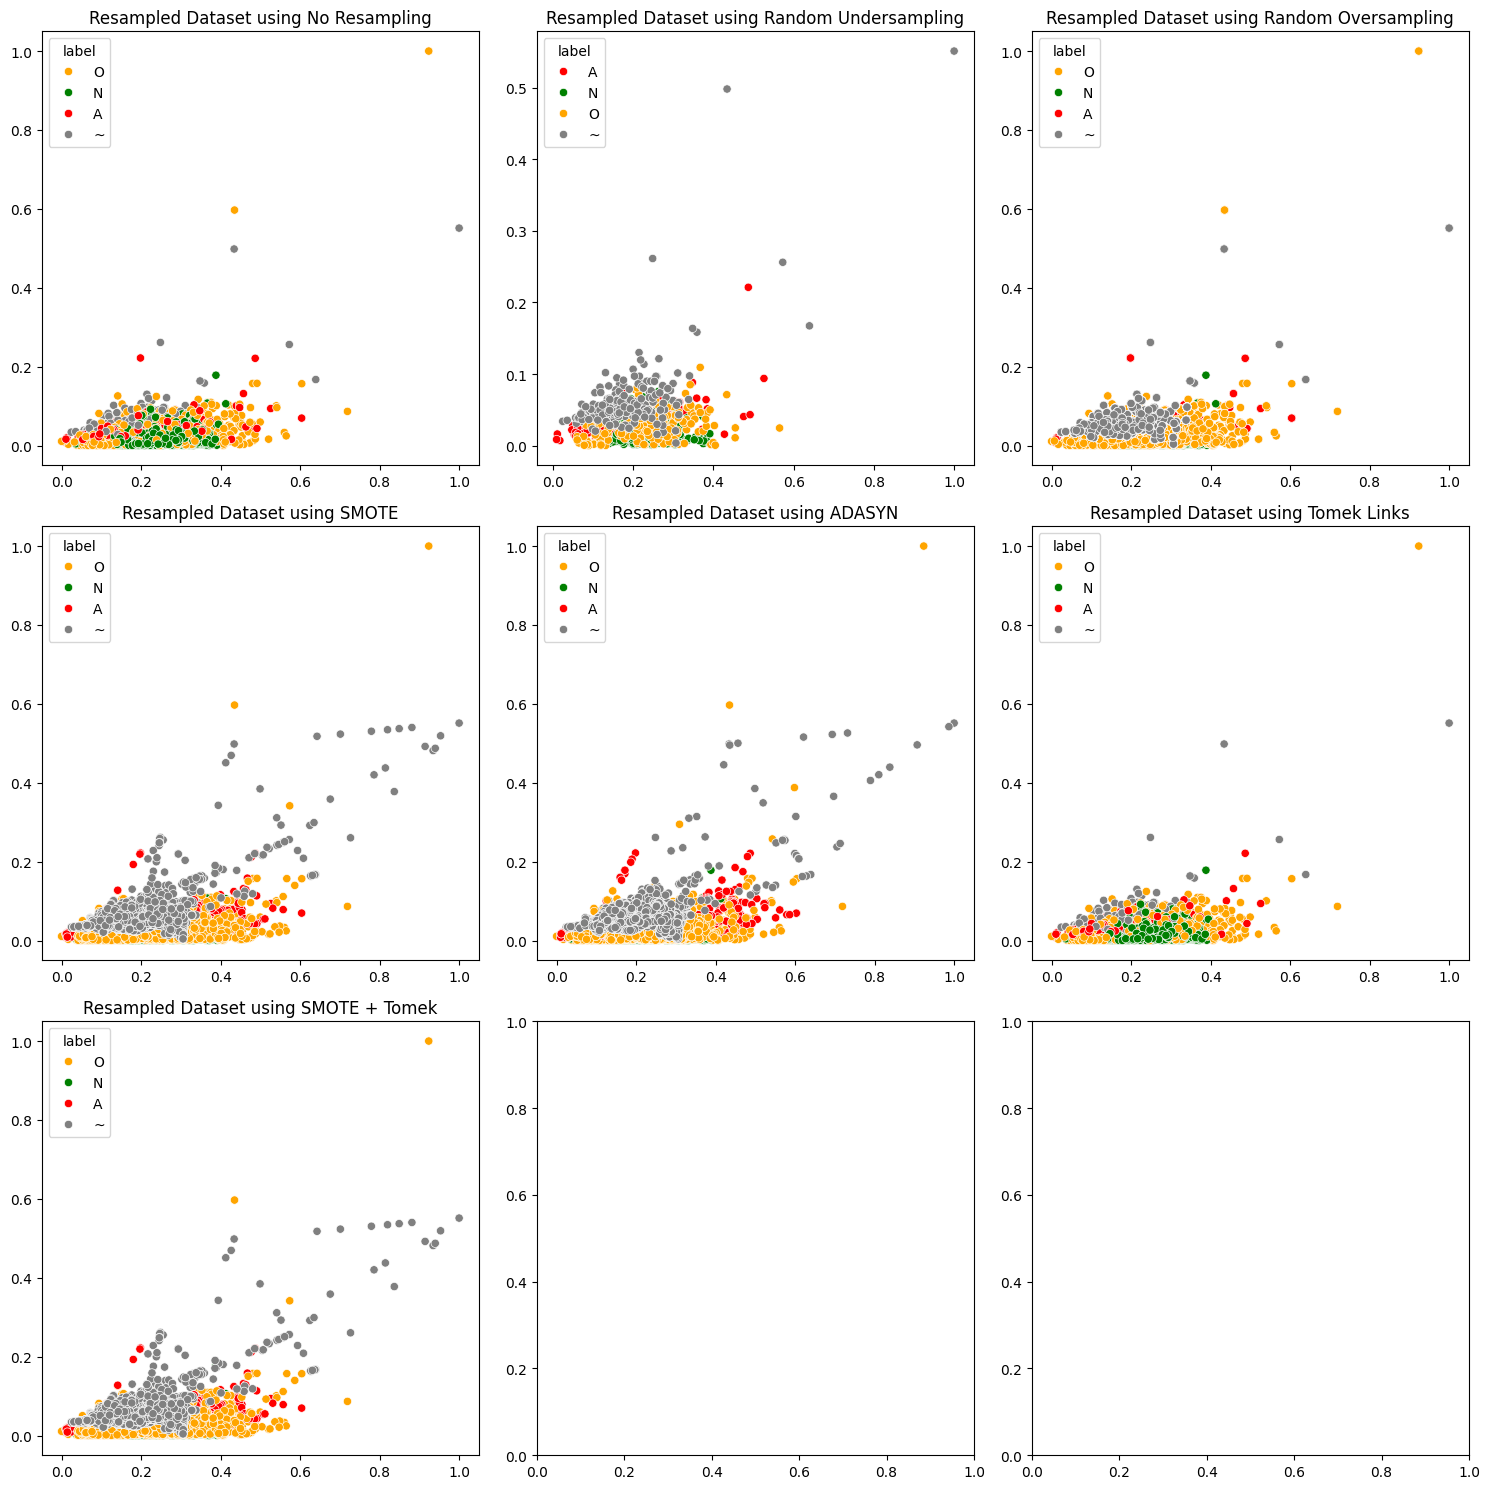

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Split data into train test set
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(pan_tompkins_results.drop('label', axis = 1),
                                                    pan_tompkins_results['label'],
                                                    test_size = 0.4,
                                                    random_state = 42)

# Scale the dataset on both train and test sets.
# Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
scaler = MinMaxScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

def plot_data(X, y, ax, title):
    
    color_palette = {'N': 'green', 'O': 'orange', 'A': 'red', '~': 'gray'}

    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax, palette=color_palette)
    ax.set_title(title)

# let's plot the data for each resampling method
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
i = 0
j = 0 
for resampling_name, resampling_method in resampling_methods.items():
    if resampling_method is not None:
      X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train1, y_train1)
      plot_data(X_train_resampled, y_train_resampled, ax[i,j], title=f'Resampled Dataset using {resampling_name}')
    else:
      plot_data(X_train1, y_train1, ax[i,j], title=f'Resampled Dataset using {resampling_name}')
    j += 1
    if j == 3:
      i += 1
      j = 0
plt.tight_layout()
plt.show()

In [15]:
# Split into trainval and holdout
X, y = pan_tompkins_results.drop('label', axis=1), pan_tompkins_results['label']

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=143,
                                                                  test_size=0.25,
                                                                  stratify=y)

In [16]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=143),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

In [8]:
from sklearn.metrics import average_precision_score
from imblearn.metrics import sensitivity_score, geometric_mean_score
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=5)

results = {}

for model_name, model in models_dict.items():
    val_rec_scores = []
    val_gmean_scores = []
    val_prauc_scores = [] 

    for resampling_name, resampling_method in resampling_methods.items():
        start_time = time.time()
        for train_index, val_index in skf.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            pipeline = Pipeline([(resampling_name, resampling_method),
                               (model_name, model)])
            pipeline.fit(X_train, y_train)

            train_preds = pipeline.predict(X_train)
            val_preds = pipeline.predict(X_val)
            val_proba = pipeline.predict_proba(X_val)

            # Calculate average precision for each class and take mean
            val_prauc_score = np.mean([
                average_precision_score(y_val == class_label, 
                                     val_proba[:, idx])
                for idx, class_label in enumerate(pipeline.classes_)
            ])

            val_rec_score = sensitivity_score(y_val, val_preds, average='macro')
            val_gmean_score = geometric_mean_score(y_val, val_preds)

            val_rec_scores.append(val_rec_score)
            val_gmean_scores.append(val_gmean_score)
            val_prauc_scores.append(val_prauc_score)
        
        end_time = time.time()
        
        if resampling_name not in results:
            results[resampling_name] = {}
        results[resampling_name][model_name] = {
            'ave_val_recall': np.mean(val_rec_scores) * 100,
            'ave_val_gmean_score': np.mean(val_gmean_scores) * 100,
            'ave_val_prauc_score': np.mean(val_prauc_scores) * 100,
            'run_time': end_time - start_time
        }
        print(f"Report Generated for {model_name}: {resampling_name} in {results[resampling_name][model_name]['run_time']:.2f} seconds")
        print(f"Average Recall: {results[resampling_name][model_name]['ave_val_recall']:.2f}%")
        print(f"Average G-Mean: {results[resampling_name][model_name]['ave_val_gmean_score']:.2f}%")
        print(f"Average PR AUC: {results[resampling_name][model_name]['ave_val_prauc_score']:.2f}%")
        print("Run Time: ", results[resampling_name][model_name]['run_time'])

results = pd.DataFrame(results).T
display(results)

Report Generated for KNeighborsClassifier: No Resampling in 0.71 seconds
Average Recall: 34.93%
Average G-Mean: 23.90%
Average PR AUC: 34.44%
Run Time:  0.7070777416229248
Report Generated for KNeighborsClassifier: Random Undersampling in 0.55 seconds
Average Recall: 38.23%
Average G-Mean: 31.78%
Average PR AUC: 33.04%
Run Time:  0.5481488704681396
Report Generated for KNeighborsClassifier: Random Oversampling in 1.36 seconds
Average Recall: 38.70%
Average G-Mean: 33.85%
Average PR AUC: 32.70%
Run Time:  1.3589880466461182
Report Generated for KNeighborsClassifier: SMOTE in 2.18 seconds
Average Recall: 39.31%
Average G-Mean: 35.41%
Average PR AUC: 32.76%
Run Time:  2.1769449710845947
Report Generated for KNeighborsClassifier: ADASYN in 1.81 seconds
Average Recall: 39.77%
Average G-Mean: 36.54%
Average PR AUC: 32.74%
Run Time:  1.8133268356323242
Report Generated for KNeighborsClassifier: Tomek Links in 0.90 seconds
Average Recall: 38.93%
Average G-Mean: 34.45%
Average PR AUC: 33.06%
Ru

/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report Generated for LogisticRegressor: No Resampling in 0.29 seconds
Average Recall: 35.27%
Average G-Mean: 22.44%
Average PR AUC: 42.93%
Run Time:  0.28980302810668945
Report Generated for LogisticRegressor: Random Undersampling in 0.13 seconds
Average Recall: 46.76%
Average G-Mean: 35.81%
Average PR AUC: 45.03%
Run Time:  0.13308095932006836


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report Generated for LogisticRegressor: Random Oversampling in 0.67 seconds
Average Recall: 50.27%
Average G-Mean: 40.12%
Average PR AUC: 46.06%
Run Time:  0.6702783107757568


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report Generated for LogisticRegressor: SMOTE in 0.66 seconds
Average Recall: 52.23%
Average G-Mean: 42.24%
Average PR AUC: 46.42%
Run Time:  0.6608030796051025


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report Generated for LogisticRegressor: ADASYN in 0.78 seconds
Average Recall: 53.35%
Average G-Mean: 43.70%
Average PR AUC: 46.57%
Run Time:  0.7789676189422607


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report Generated for LogisticRegressor: Tomek Links in 0.40 seconds
Average Recall: 50.47%
Average G-Mean: 40.41%
Average PR AUC: 46.03%
Run Time:  0.40258097648620605


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report Generated for LogisticRegressor: SMOTE + Tomek in 1.08 seconds
Average Recall: 51.43%
Average G-Mean: 41.80%
Average PR AUC: 46.25%
Run Time:  1.0846750736236572
Report Generated for RandomForestClassifier: No Resampling in 7.38 seconds
Average Recall: 56.45%
Average G-Mean: 52.13%
Average PR AUC: 68.73%
Run Time:  7.382198095321655
Report Generated for RandomForestClassifier: Random Undersampling in 1.00 seconds
Average Recall: 61.52%
Average G-Mean: 58.51%
Average PR AUC: 64.86%
Run Time:  1.001485824584961
Report Generated for RandomForestClassifier: Random Oversampling in 11.33 seconds
Average Recall: 61.11%
Average G-Mean: 58.38%
Average PR AUC: 65.87%
Run Time:  11.333693265914917
Report Generated for RandomForestClassifier: SMOTE in 17.42 seconds
Average Recall: 62.41%
Average G-Mean: 60.24%
Average PR AUC: 66.11%
Run Time:  17.420790910720825
Report Generated for RandomForestClassifier: ADASYN in 17.22 seconds
Average Recall: 63.32%
Average G-Mean: 61.48%
Average PR AUC:

,KNeighborsClassifier,LogisticRegressor,RandomForestClassifier,DecisionTreeClassifier,GradientBoostingClassifier
No Resampling,"{'ave_val_recall': 34.934897133021195, 'ave_va...","{'ave_val_recall': 35.27472848405186, 'ave_val...","{'ave_val_recall': 56.445623908178334, 'ave_va...","{'ave_val_recall': 52.3199031482467, 'ave_val_...","{'ave_val_recall': 58.85621090190977, 'ave_val..."
Random Undersampling,"{'ave_val_recall': 38.232231533853685, 'ave_va...","{'ave_val_recall': 46.7622816999466, 'ave_val_...","{'ave_val_recall': 61.516268031262165, 'ave_va...","{'ave_val_recall': 53.71424787068106, 'ave_val...","{'ave_val_recall': 62.514550132059085, 'ave_va..."
Random Oversampling,"{'ave_val_recall': 38.69845117507029, 'ave_val...","{'ave_val_recall': 50.270170958329764, 'ave_va...","{'ave_val_recall': 61.107636406344476, 'ave_va...","{'ave_val_recall': 52.90899372797496, 'ave_val...","{'ave_val_recall': 64.3992488030393, 'ave_val_..."
SMOTE,"{'ave_val_recall': 39.30570808037251, 'ave_val...","{'ave_val_recall': 52.23310659418659, 'ave_val...","{'ave_val_recall': 62.414613284616394, 'ave_va...","{'ave_val_recall': 53.75740774671709, 'ave_val...","{'ave_val_recall': 65.44529906328881, 'ave_val..."
ADASYN,"{'ave_val_recall': 39.77277126960855, 'ave_val...","{'ave_val_recall': 53.348366148150376, 'ave_va...","{'ave_val_recall': 63.317016691835704, 'ave_va...","{'ave_val_recall': 53.877186827560095, 'ave_va...","{'ave_val_recall': 65.98558629439073, 'ave_val..."
Tomek Links,"{'ave_val_recall': 38.931059176209196, 'ave_va...","{'ave_val_recall': 50.473935212250964, 'ave_va...","{'ave_val_recall': 62.49193101822211, 'ave_val...","{'ave_val_recall': 54.02941904456636, 'ave_val...","{'ave_val_recall': 64.85813671997995, 'ave_val..."
SMOTE + Tomek,"{'ave_val_recall': 39.24921430285712, 'ave_val...","{'ave_val_recall': 51.42663173262868, 'ave_val...","{'ave_val_recall': 63.07983867025821, 'ave_val...","{'ave_val_recall': 54.50058746316684, 'ave_val...","{'ave_val_recall': 65.37242914824557, 'ave_val..."


No Resampling : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(68.73284544671081)}
Random Undersampling : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(64.85589151181998)}
Random Oversampling : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(65.86830982658928)}
SMOTE : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(66.11370806035393)}
ADASYN : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(66.20833332301915)}
Tomek Links : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(66.54406636749935)}
SMOTE + Tomek : {'model': 'RandomForestClassifier', 'prauc_score': np.float64(66.6023178917742)}


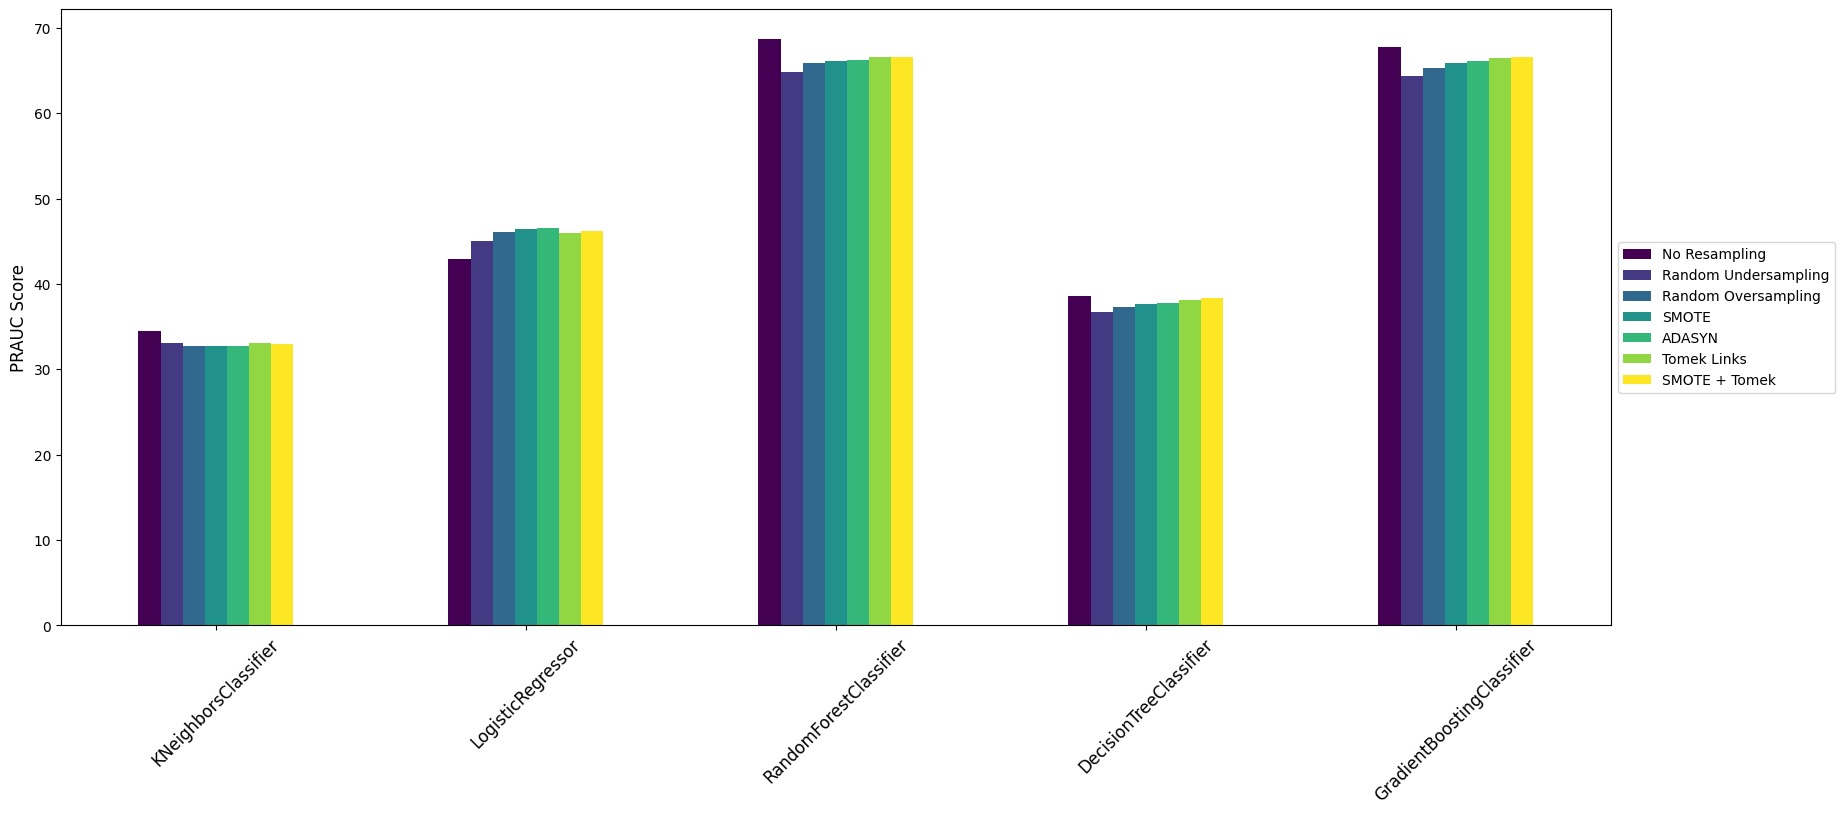

In [9]:
plot_res = pd.DataFrame(index=models_dict.keys())
# loop the results and store the ave_val_prauc_score
best_results = {}
for resampling_name, resampling_method in resampling_methods.items():
    for model_name, model_method in models_dict.items():
        # print(model_name, ':', resampling_name, ':', results[model_name][resampling_name]['ave_val_prauc_score'])
        plot_res.loc[model_name, resampling_name] = results[model_name][resampling_name]['ave_val_prauc_score']
        if resampling_name not in best_results:
            best_results[resampling_name] = {'model': model_name, 'prauc_score': results[model_name][resampling_name]['ave_val_prauc_score']}
        elif results[model_name][resampling_name]['ave_val_prauc_score'] > best_results[resampling_name]['prauc_score']:
            best_results[resampling_name] = {'model': model_name, 'prauc_score': results[model_name][resampling_name]['ave_val_prauc_score']}

for best in best_results:
    print(best, ':', best_results[best])

_, ax = plt.subplots(figsize=(20, 8))
plot_res.plot.bar(ax=ax, cmap='viridis')
ax.set_ylabel('PRAUC Score', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.show()


### It appears that "no resampling" has better performance.
### So, we will keep original dataset and try cost sensitive learning.

In [17]:
# Try cost sensitive learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assign higher cost to false negatives
Weight_Multiplier = 10
class_weights = {'N': 1, 'O': Weight_Multiplier, 'A': Weight_Multiplier, '~': 1}


# Initialize and train a logistic regression model with cost-sensitive learning
# Increase the number of iterations to allow for convergence
model = LogisticRegression(class_weight=class_weights, max_iter=10000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
# add labels to the confusion matrix
cm = pd.DataFrame(cm, index=['A', 'N', 'O', '~'], columns=['A', 'N', 'O', '~'])

print("Confusion Matrix:\n", cm)



Classification Report:
               precision    recall  f1-score   support

           A       0.57      0.42      0.48       202
           N       0.91      0.18      0.31      1523
           O       0.33      0.89      0.48       760
           ~       0.73      0.16      0.26        70

    accuracy                           0.41      2555
   macro avg       0.63      0.41      0.38      2555
weighted avg       0.70      0.41      0.37      2555

Confusion Matrix:
     A    N     O   ~
A  84    0   118   0
N   9  280  1233   1
O  50   27   680   3
~   5    2    52  11


In [18]:
# Lets try CSL using Random Forest


# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assign higher cost to false negatives
class_weights = {'N': 1, 'O': 1, 'A': 1, '~': 1}


# Initialize and train a logistic regression model with cost-sensitive learning
# Increase the number of iterations to allow for convergence
model = RandomForestClassifier(
  n_estimators=92,
  max_depth=9,
  class_weight=class_weights, 
  random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
# add labels to the confusion matrix
cm = pd.DataFrame(cm, index=['A', 'N', 'O', '~'], columns=['A', 'N', 'O', '~'])

print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           A       0.75      0.40      0.52       202
           N       0.77      0.93      0.84      1523
           O       0.65      0.48      0.55       760
           ~       0.62      0.30      0.40        70

    accuracy                           0.74      2555
   macro avg       0.70      0.53      0.58      2555
weighted avg       0.73      0.74      0.72      2555

Confusion Matrix:
     A     N    O   ~
A  80    44   77   1
N   2  1422   97   2
O  23   362  365  10
~   1    26   22  21


### Cost Sensitive Learning also did not yield better result because we do not have cost function. 
Most literature use accuracy as measure, as such, we cannot assign cost function and use accuracy to measure instead.

### We will stop here... and move on to other methods.